In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from keras.models import Model
from keras import backend as K

from PIL import Image
from scipy.misc import imsave
import numpy as np
import scipy

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.


In [2]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [3]:
img = Image.open("./images/bird.png")

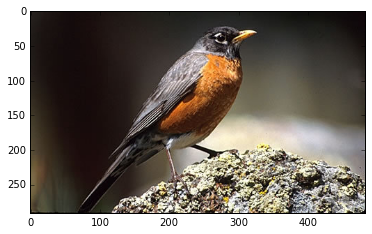

In [4]:
plt.imshow(img)

In [5]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [6]:
model = VGG16_Avg(include_top=False)

In [8]:
# this value can change as feed new image
content_layer = model.get_layer('block5_conv1').output
# given input get layer output
content_layer_model = Model(model.input, content_layer)
# now have static value for bird image
content_targ = K.variable(content_layer_model.predict(img_arr))

In [9]:
class Evaluator(object):
    def __init__(self, f, shape): self.f, self.shape = f, shape
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shape)])
        return loss_.astype(np.float64)
    def grads(self, x):
        return self.grad_values.flatten().astype(np.float64)

In [12]:
content_loss = K.mean(metrics.mse(content_layer, content_targ))
# take gradients of loss wrt to input image which is what we are trying to optimize
gradients = K.gradients(content_loss, content_layer_model.input)
# take the input tensors and outputs. Both lists
optimize_funtion = K.function([model.input], [content_loss] + gradients) 
eval_function = Evaluator(optimize_funtion, shp)

In [13]:
def solve_image(eval_obj, n_iter, x):
    for i in range(n_iter):
        x, min_value, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print('Current loss value:', min_value)
        #imsave('./images/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

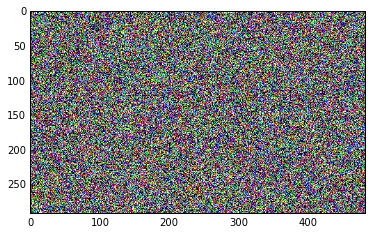

In [14]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 100
x = rand_img(shp)
plt.imshow(x[0])

In [12]:
#bird_x = solve_image(eval_function, 10, x)

Current loss value: 66.3480224609
Current loss value: 21.3210716248
Current loss value: 11.8671598434
Current loss value: 8.14737033844
Current loss value: 6.36600732803
Current loss value: 5.40655469894
Current loss value: 4.77780485153
Current loss value: 4.28534793854
Current loss value: 3.87828493118
Current loss value: 3.53832173347


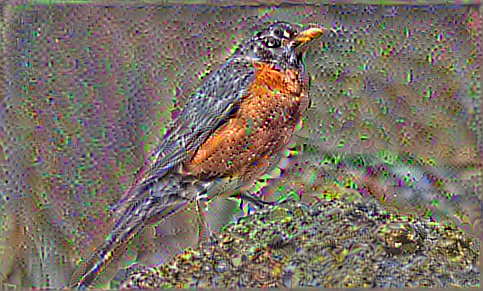

In [13]:
#Image.fromarray(np.uint8(deproc(bird_x, shp)[0]))

## Style 

In [72]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))


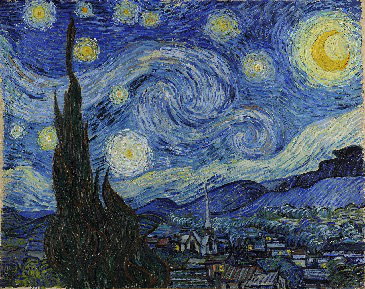

In [73]:
style = Image.open("./images/stary.jpg"); style

In [74]:
style_arr = preproc(np.expand_dims(style, 0))
style_shp = style_arr.shape

In [75]:
style_model_only = VGG16_Avg(include_top=False, input_shape=style_arr.shape[1:])

In [78]:
style_outputs = {l.name: l.output for l in style_model_only.layers}
style_layers = [style_outputs['block{}_conv1'.format(i)] for i in range(1,3)]
style_layer_model = Model(style_model_only.input, style_layers)
style_targs = [K.variable(o) for o in style_layer_model.predict(style_arr)]

In [37]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss_fn(x, targ):
    return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [45]:
## need the [0] to take the first image in the batch
style_loss = sum([style_loss_fn(x[0], targ[0]) for x, targ in zip(style_layers, style_targs)])
grads = K.gradients(style_loss, style_model.input)
fn = K.function([style_model.input], [style_loss] + grads)
eval_fn = Evaluator(fn, shp)

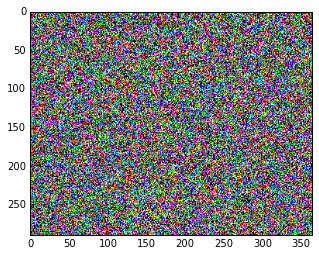

In [85]:
x = rand_img(style_shp)
x = scipy.ndimage.gaussian_filter(x, [0,0,0,0])
plt.imshow(x[0])

In [86]:
#style_x = solve_image(eval_fn, 10, x)

In [87]:
#Image.fromarray(np.uint8(deproc(style_x, shp)[0]))

## Combine Loss

In [107]:
style_wgt = 0.1
style_wgts = [5.0,4.0,3.0,2.0,1.0]

style_layers = [style_outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = style_outputs[content_name]

style_model = Model(style_model_only.input, style_layers)
style_targets = [K.variable(o) for o in style_model.predict(style_arr)]

content_model = Model(style_model_only.input, content_layer)
content_target = K.variable(content_model.predict(img_arr[:,:style_shp[1],:style_shp[2],:]))

loss = sum(style_loss_fn(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targets, style_wgts)) * style_wgt
loss += K.mean(metrics.mse(content_layer, content_target))
grads = K.gradients(loss, style_model_only.input)
transfer_fn = K.function([style_model_only.input], [loss]+grads)
evaluator = Evaluator(transfer_fn, style_shp)

In [108]:
style_transfer_x = solve_image(evaluator, 5, style_arr)

Current loss value: 2980.88330078
Current loss value: 2162.94726562
Current loss value: 1855.87109375
Current loss value: 1699.77600098
Current loss value: 1600.76000977


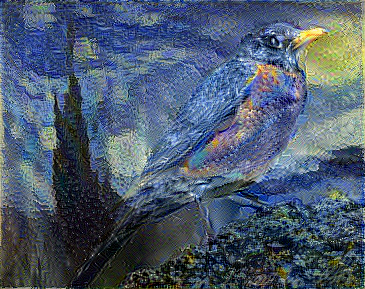

In [109]:
Image.fromarray(np.uint8(deproc(style_transfer_x, style_shp)[0]))